In [1]:
import pickle
from gensim.models import word2vec, Word2Vec
import multiprocessing
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import pandas as pd
import pickle
import requests
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from scipy.spatial.distance import cosine
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# from chembl_webresource_client.new_client import new_client
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Reshape, GRU, SpatialDropout1D, LSTM, Dropout
from keras.layers import BatchNormalization, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KDTree
from sklearn.svm import SVC

%matplotlib inline

/home/kavya/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/kavya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kavya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kavya/anaconda3/lib/python3.6/site-packages/

In [2]:
w2v = word2vec.Word2Vec.load('../skipgram/mine_300')
dimensions = 300

## Load Mapping data

In [127]:
with open("../skipgram/data/mol_sentences.pkl", "rb") as file:
    sentences = pickle.load(file)

drugs_sm = set([a[0].lower() for a in sentences])

drug_data = pd.read_csv("../data/SIDER/drug_names.tsv", sep="\t", header=None)

drug_data_names = set(drug_data[1])

viable_drugs = list(drugs_sm.intersection(drug_data_names))

UML_name = {}
name_UML = {}
for row in drug_data.iterrows():
    if row[1][1] in viable_drugs:
        UML_name[row[1][0]] = row[1][1]
        name_UML[row[1][1]] = row[1][0]   
name_identifiers = {a[0]:a[3] for a in sentences}

## Vectorisation

In [130]:
vectors = []

for dname in name_identifiers.keys():
    sentence = list(name_identifiers[dname])
    vector = []
    for word in sentence:
        try:
            vector+=list(w2v.wv.word_vec(word))
        except:
            vector+=([0 for a in range(0, dimensions)])
    arr = np.asarray(vector)
    arr = arr.reshape((int(arr.shape[0]/dimensions), dimensions) )
    name_identifiers[dname] = arr.sum(axis=0)

In [131]:
name_identifiers['goserelin'].shape

(300,)

# Side Effect Visualisation

In [132]:
ADR_data = pd.read_csv("../data/SIDER/meddra_all_indications.tsv", sep="\t", header=None)

In [133]:
ADR_data = ADR_data[[0, 3]]

In [134]:
le = LabelEncoder()
le.fit(ADR_data[3])

LabelEncoder()

In [135]:
ADR = np.unique(ADR_data[3])
ADR_dict = {a: set() for a in ADR}
for row in ADR_data.iterrows():
    ADR_dict[row[1][3]].add(row[1][0])
for k in ADR_dict.keys():
    ADR_dict[k] = list(ADR_dict[k])

In [136]:
ADR_counter = list(zip([len(ADR_dict[k]) for k in ADR_dict.keys()], list(ADR_dict.keys())))

In [137]:
counts = [a[1] for a in ADR_counter]

In [138]:
top_ADR = [a[1] for a in sorted(ADR_counter, reverse=True)[:50]]

In [145]:
df = []
for k in name_identifiers.keys():
    if k in viable_drugs:
        df.append([k]+list(name_identifiers[k]))
df = pd.DataFrame(df)
vectors = np.asarray(df[[a for a in range(1, 301)]])

In [146]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(vectors)

In [157]:
def get_graph(df, X_2d, adr, ADR_dict, name_UML):
    is_adr = [name_UML[a] in ADR_dict[adr] for a in df[0]]
    not_adr = [name_UML[a] not in ADR_dict[adr] for a in df[0]]
    plt.figure(figsize=(10, 10))
    sns.scatterplot(X_2d[is_adr, 0], X_2d[is_adr, 1], label=f"{a}", palette=sns.color_palette("hls", 10), 
                    legend="full", alpha=0.7)
    sns.scatterplot(X_2d[not_adr, 0], X_2d[not_adr, 1], label=f"Not {a}", palette=sns.color_palette("hls", 10), 
                    legend="full", alpha=0.7)

/home/kavya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


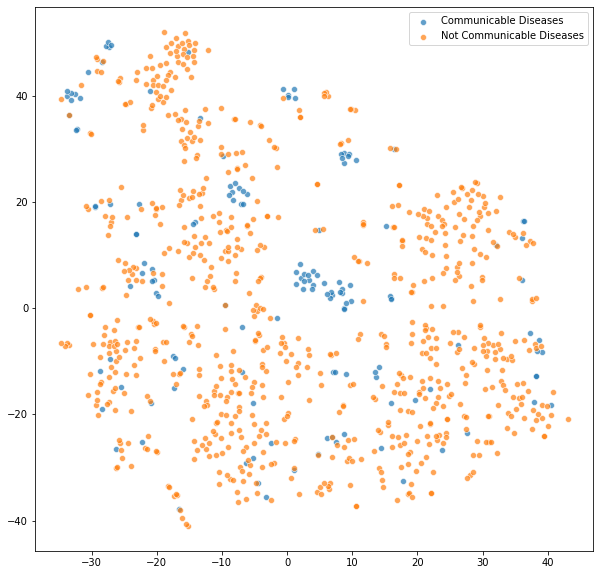

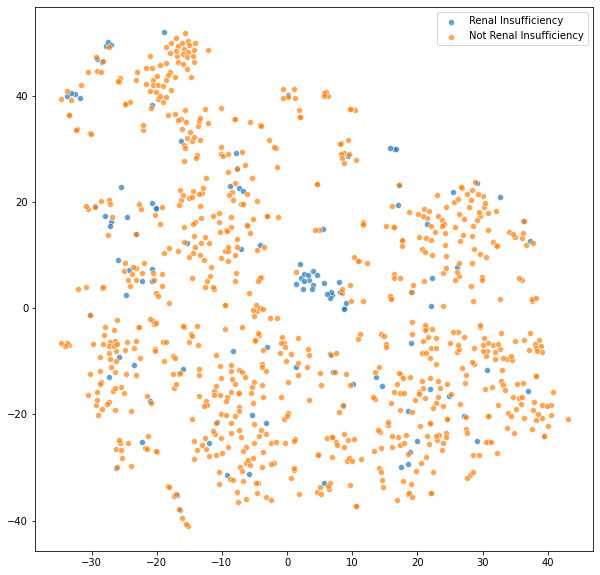

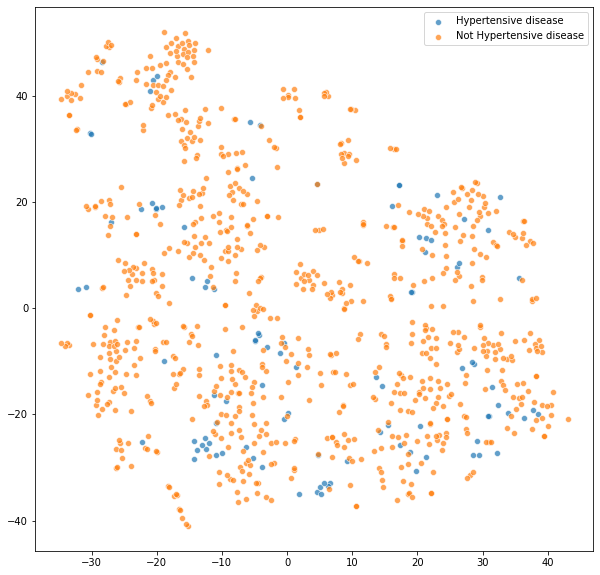

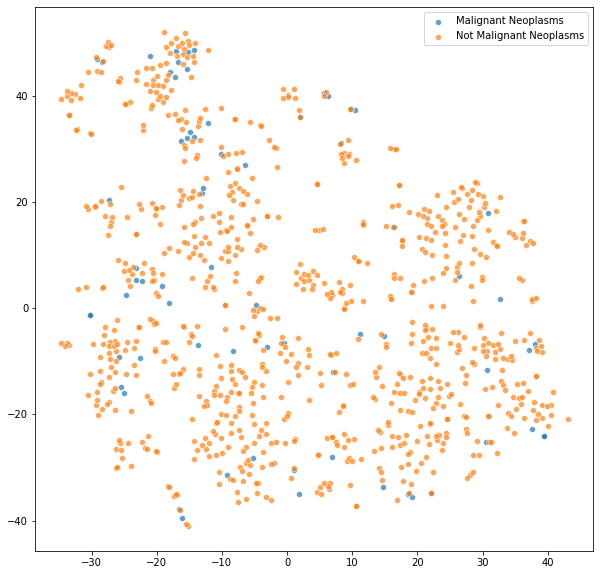

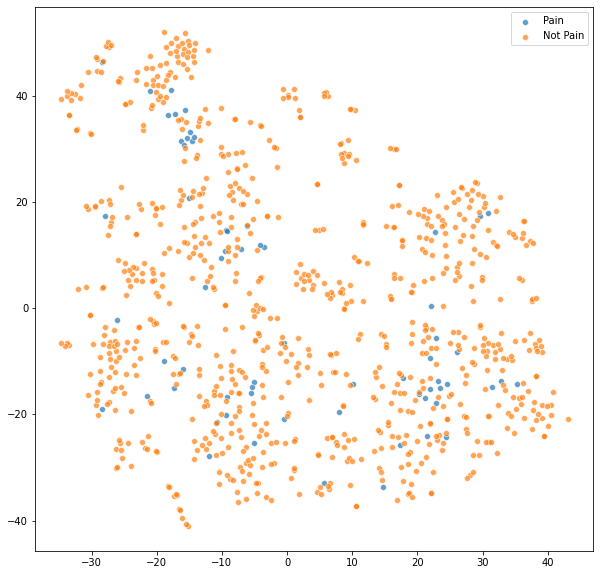

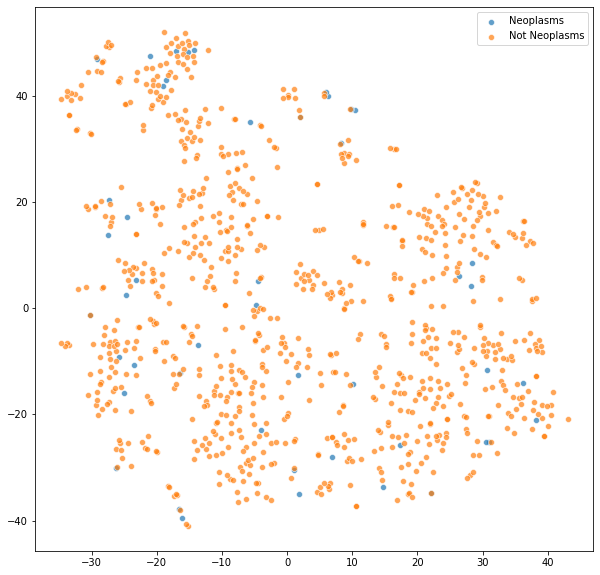

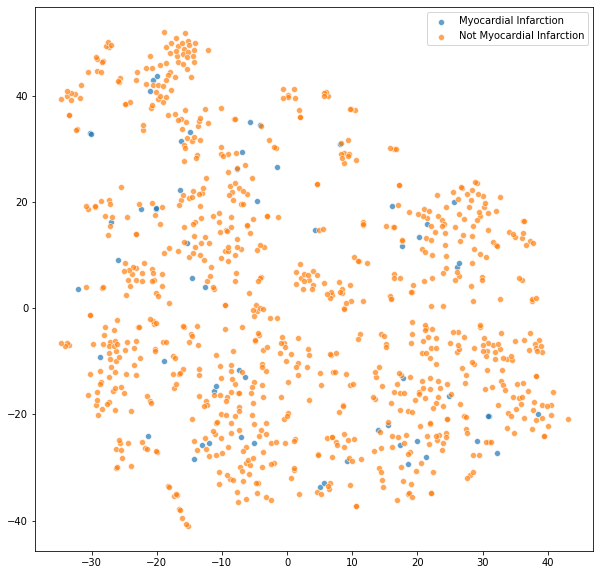

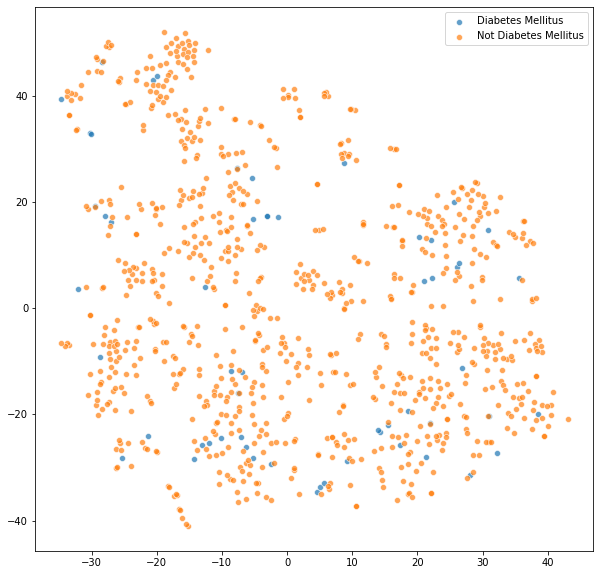

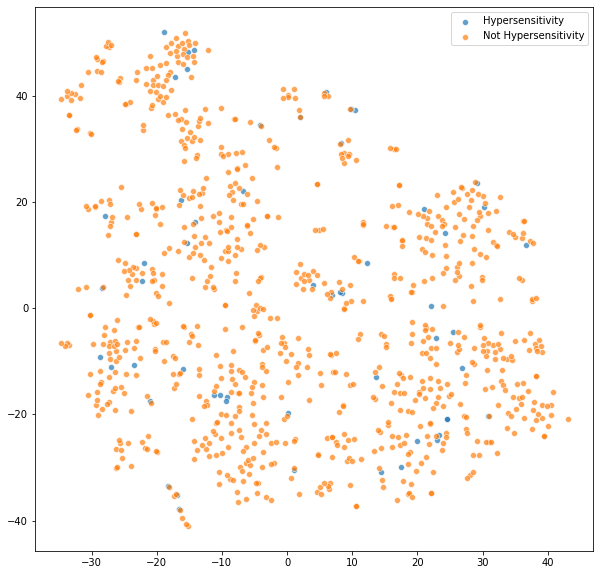

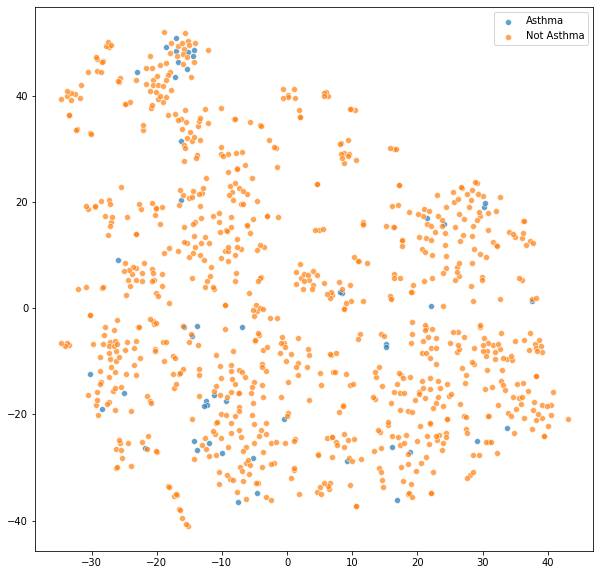

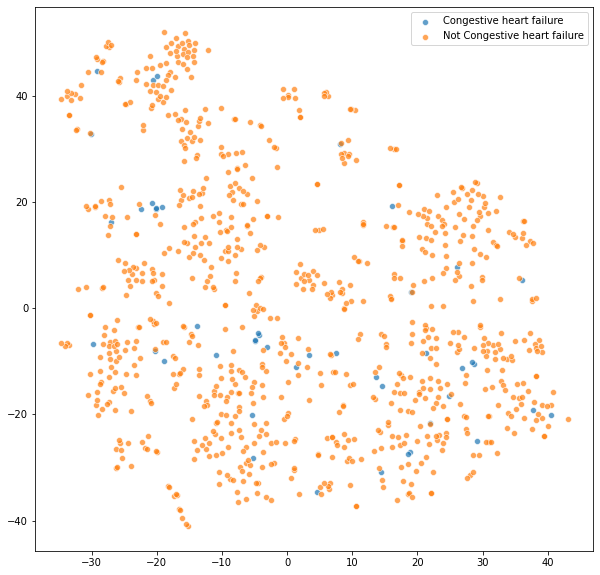

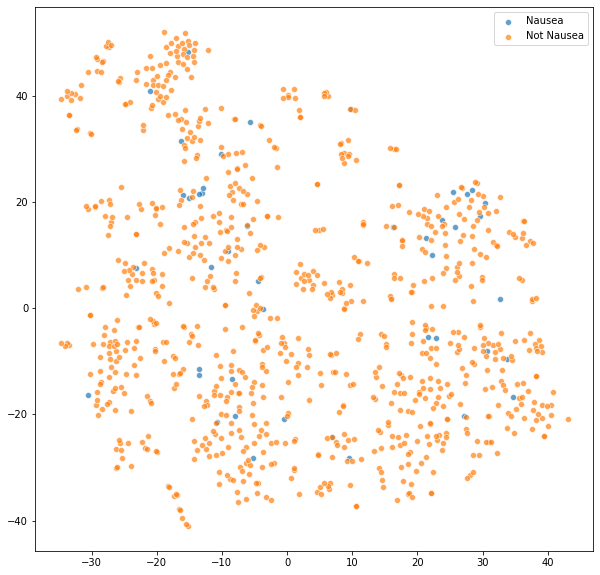

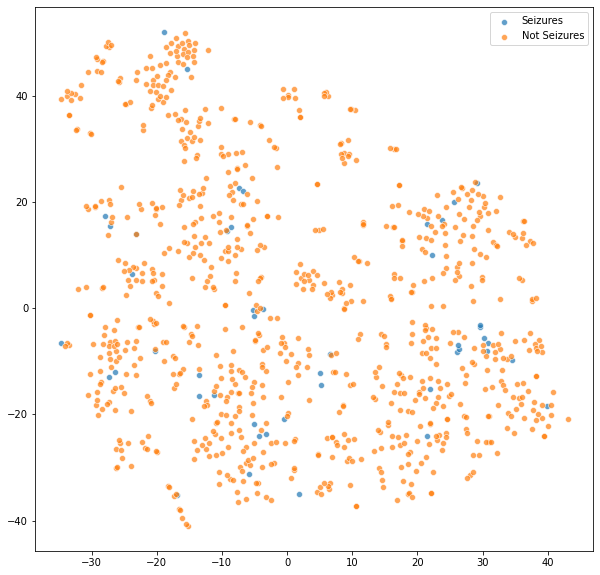

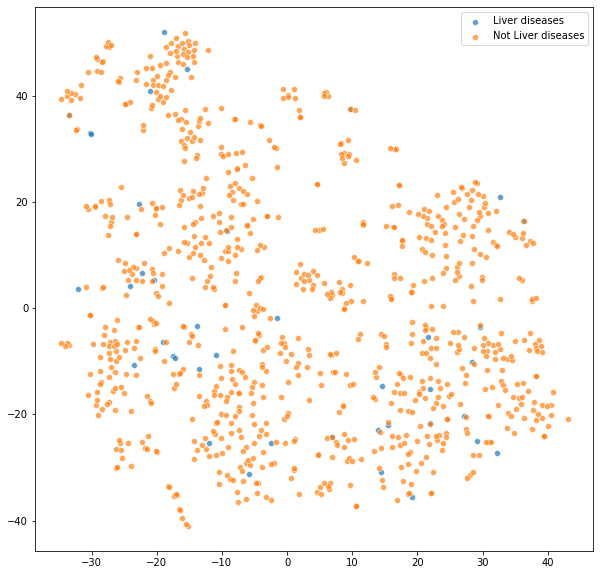

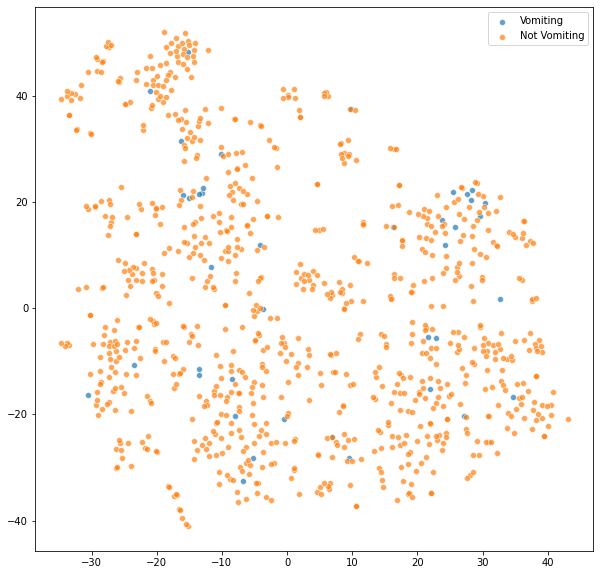

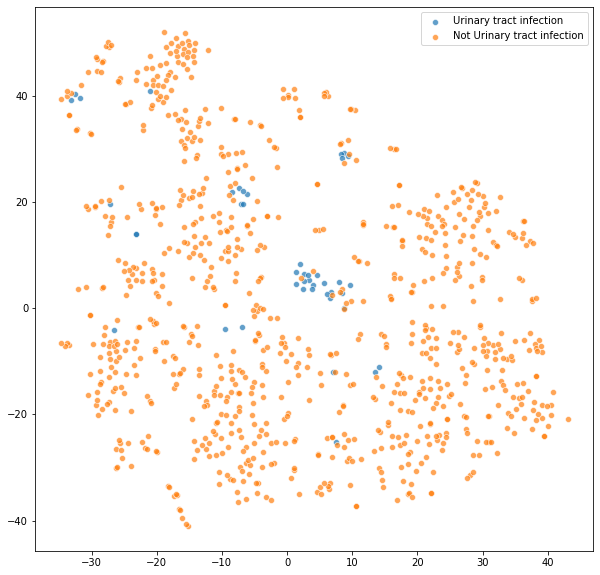

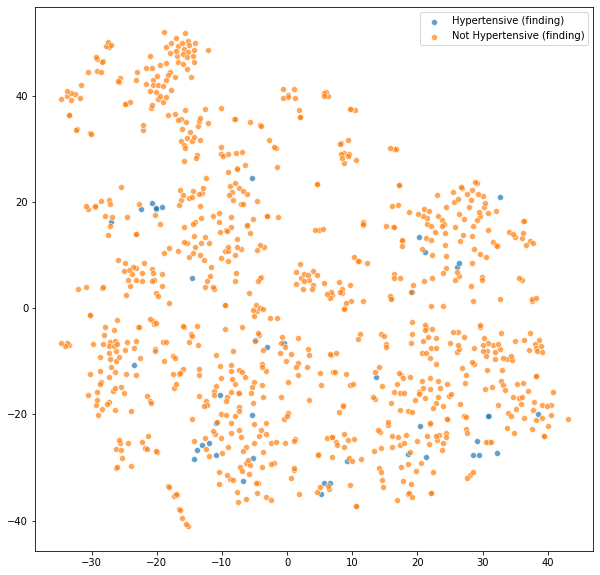

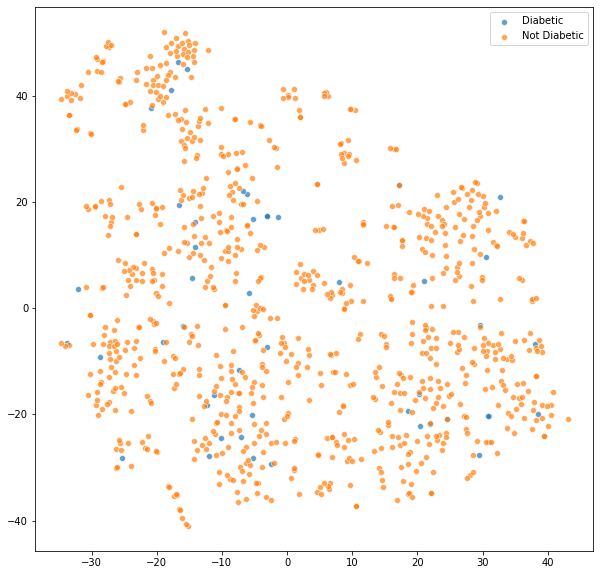

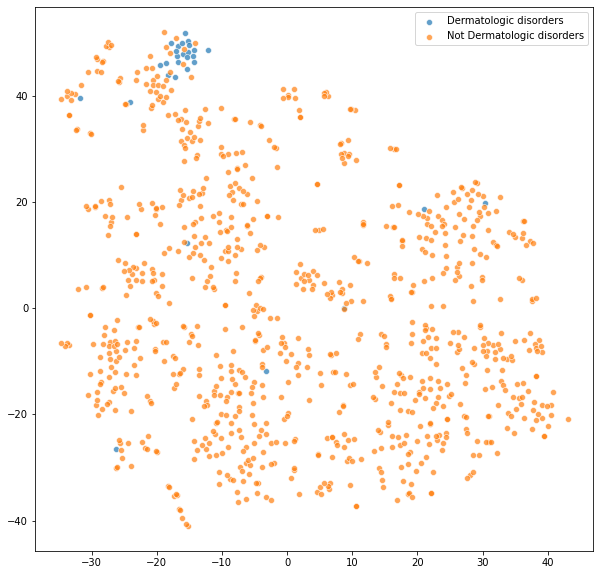

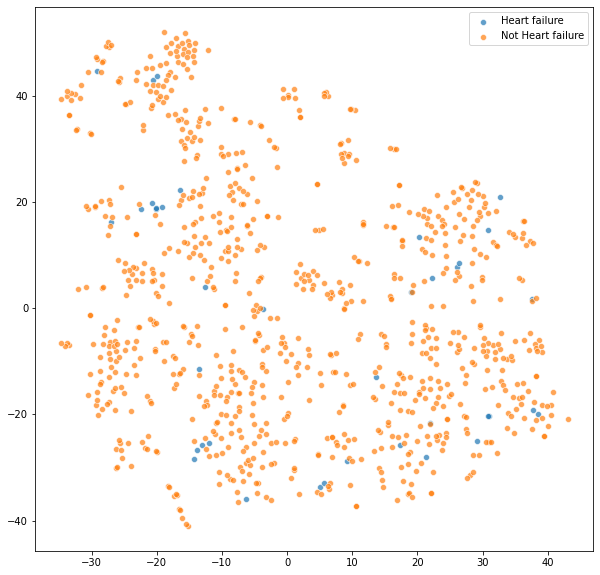

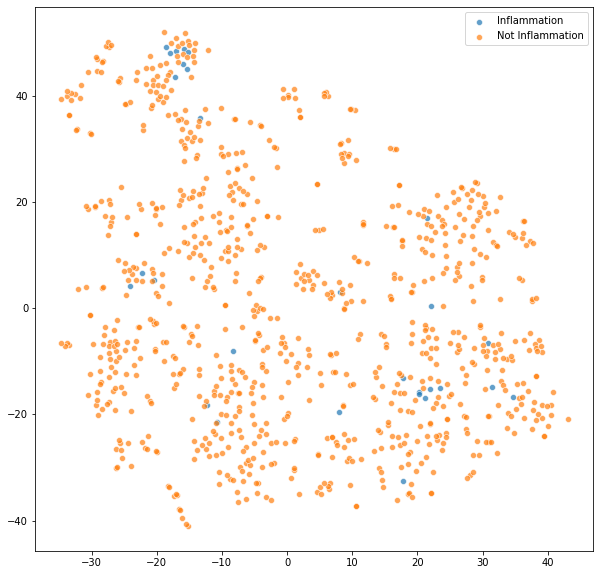

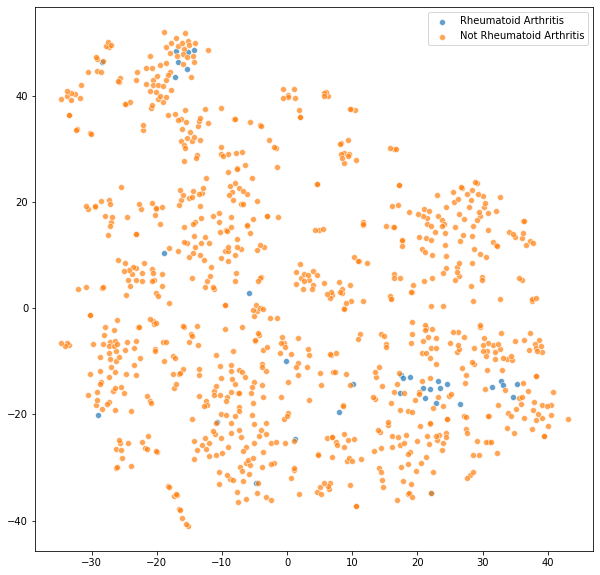

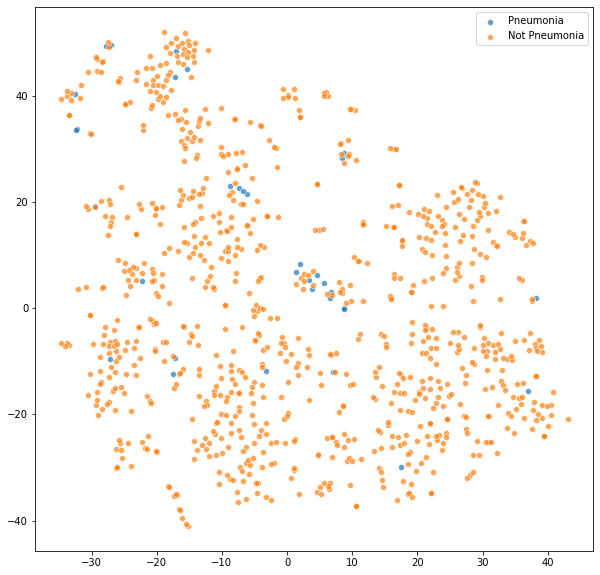

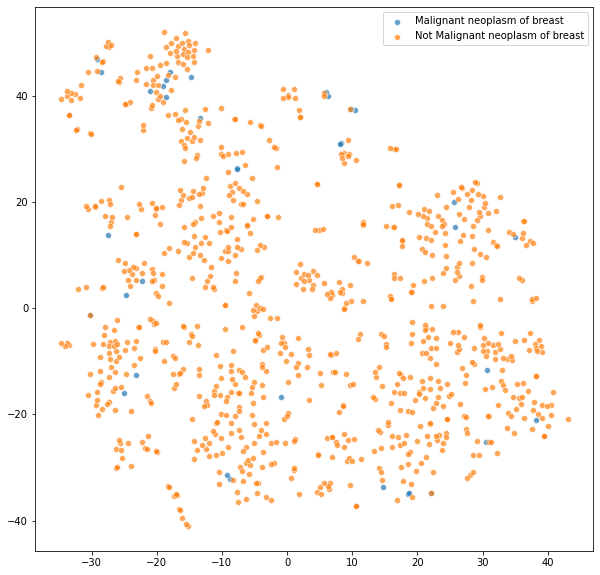

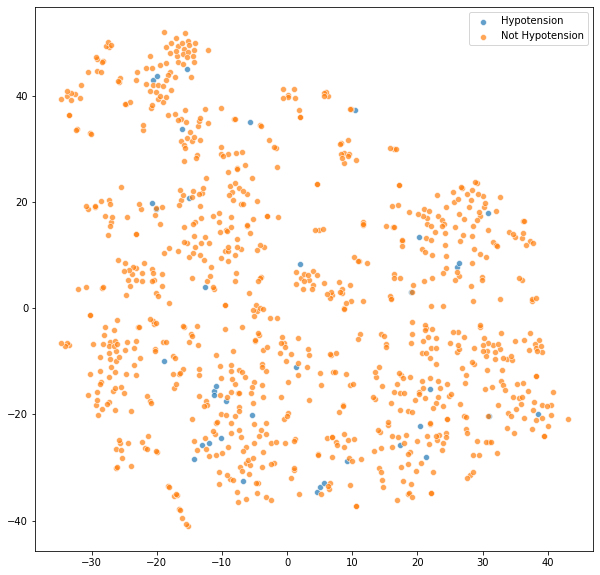

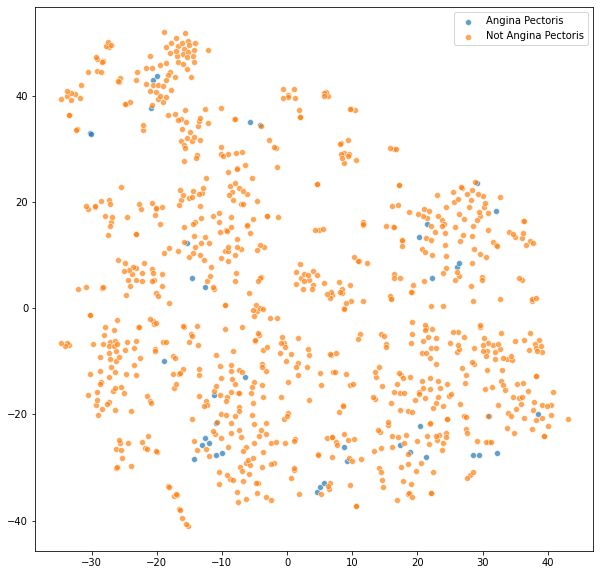

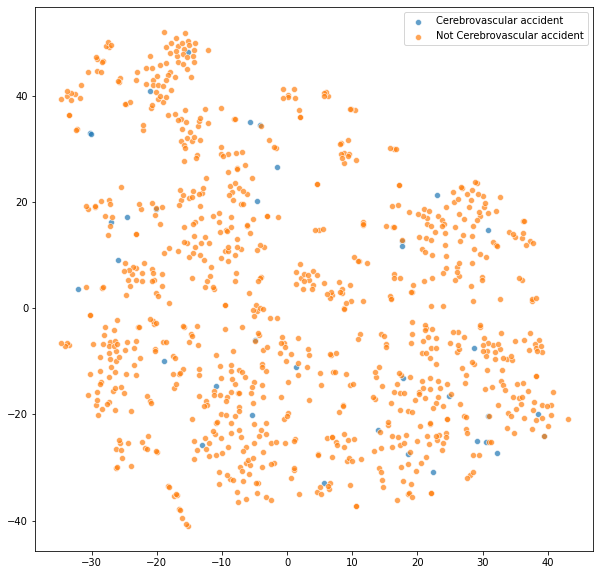

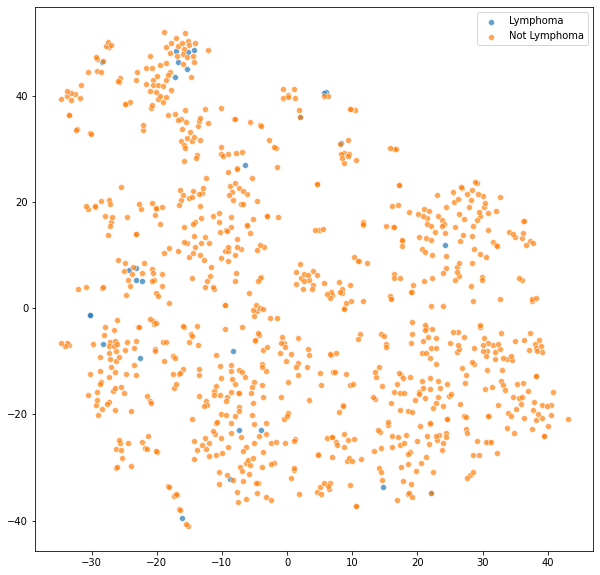

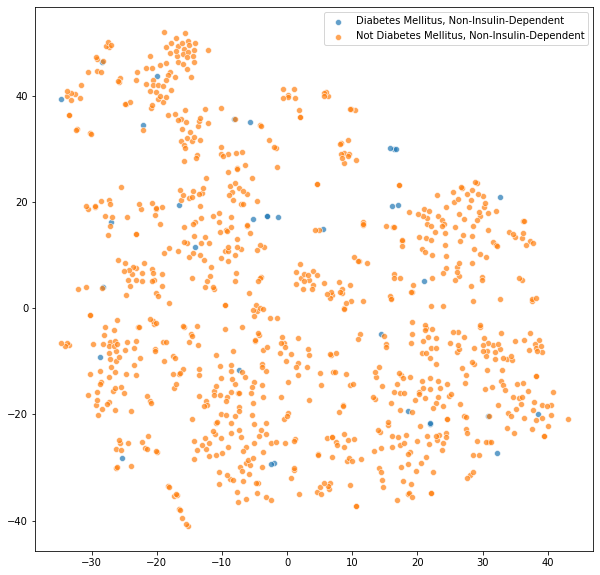

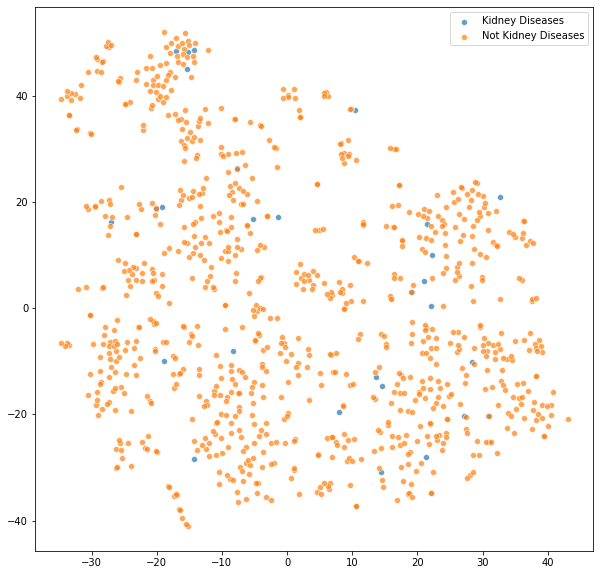

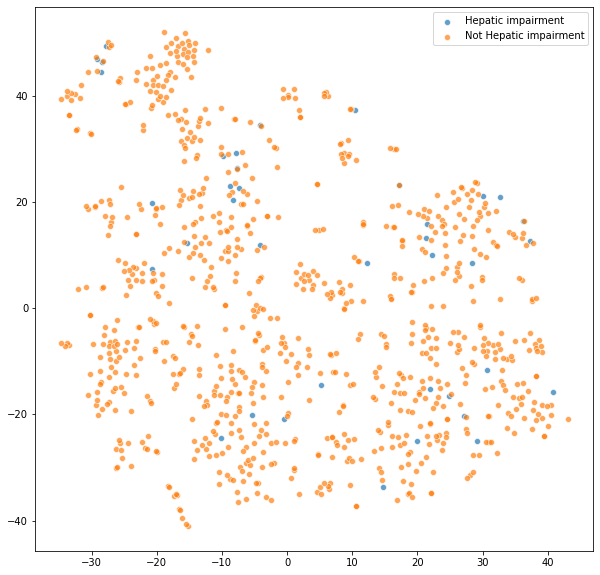

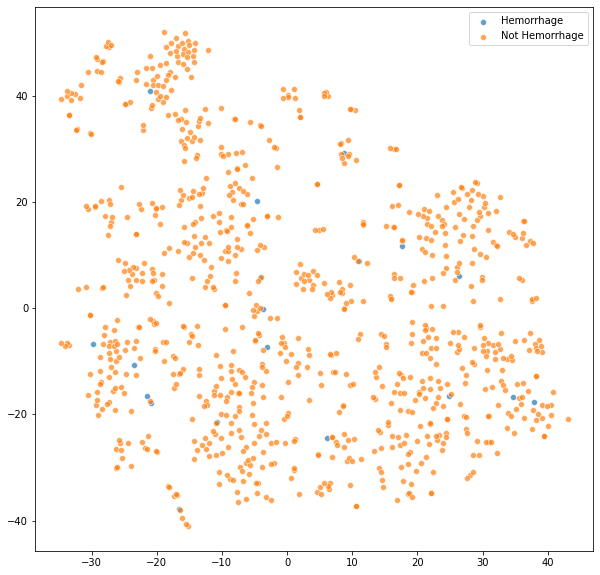

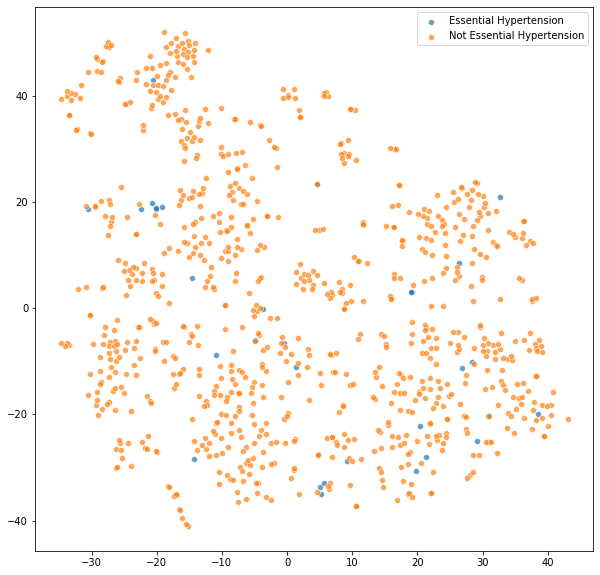

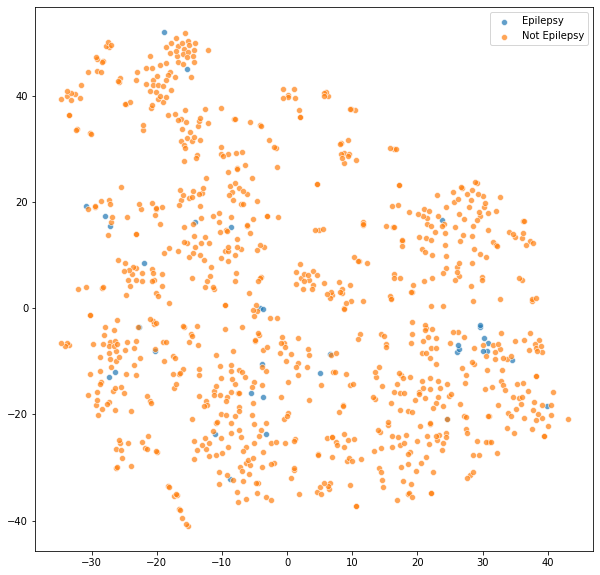

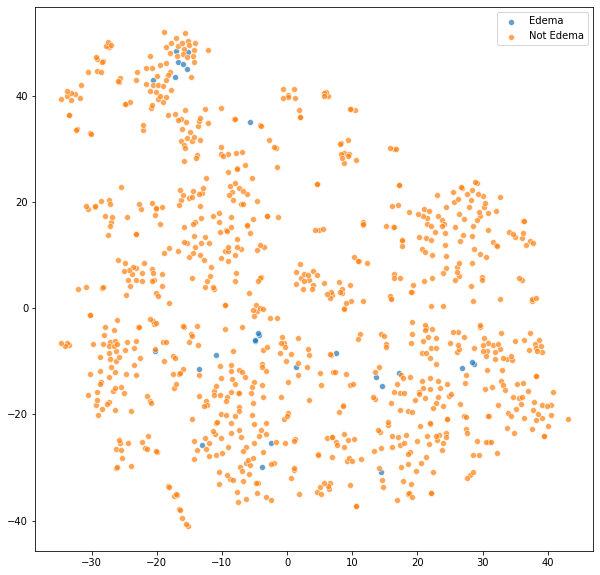

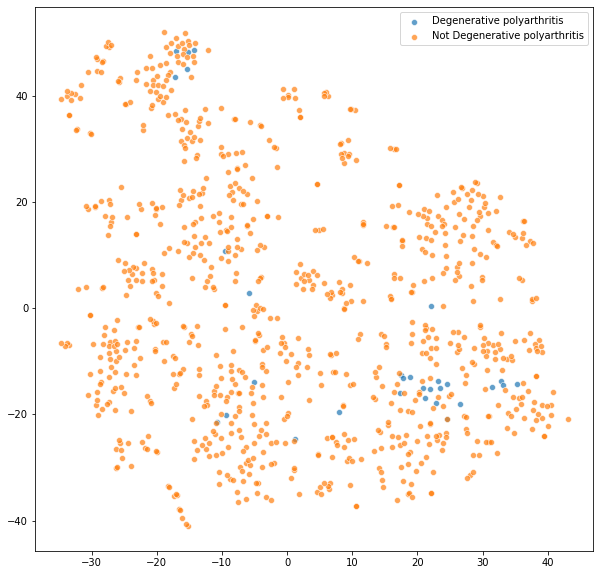

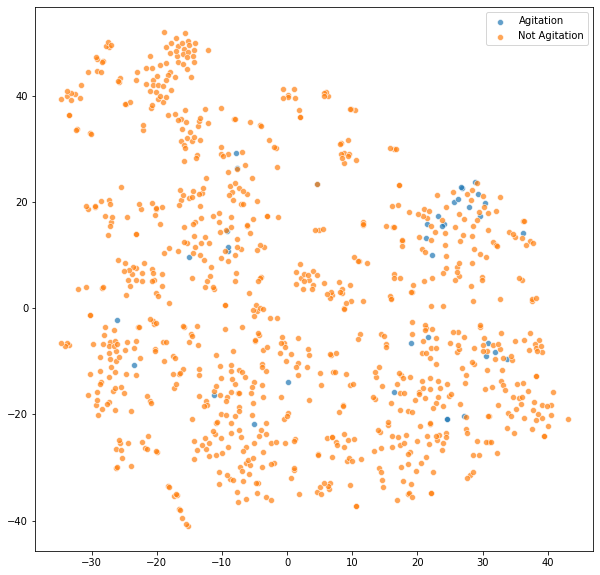

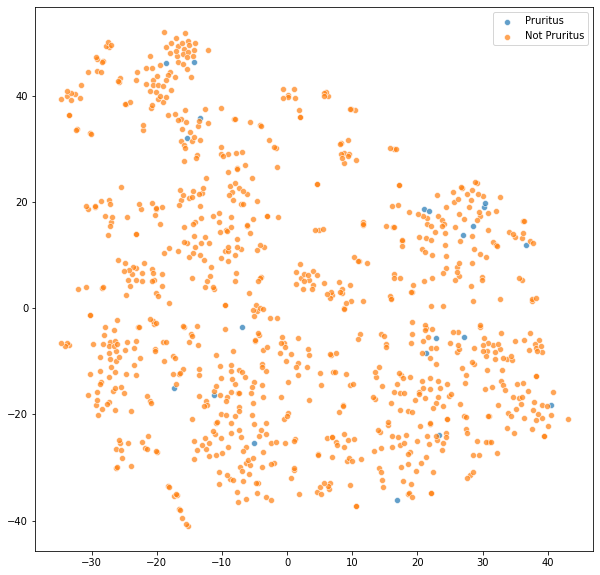

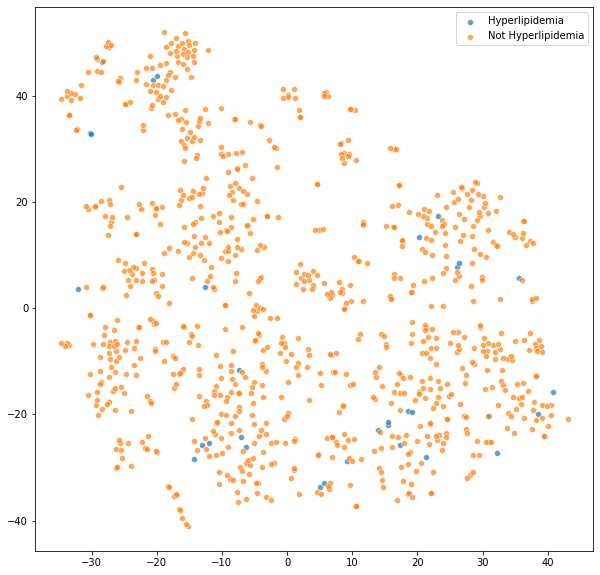

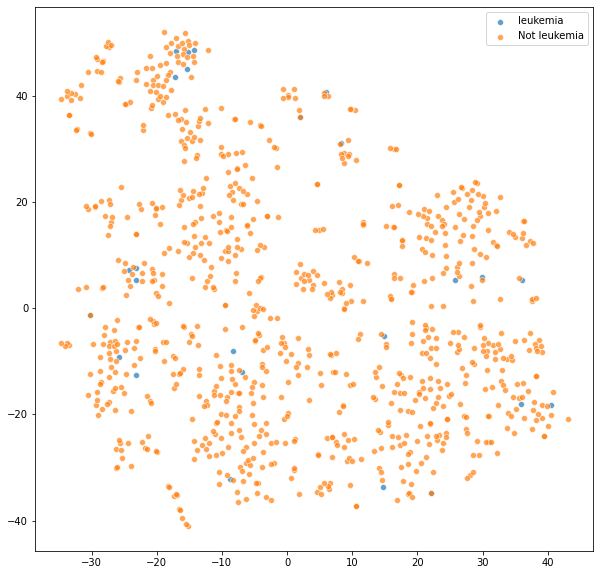

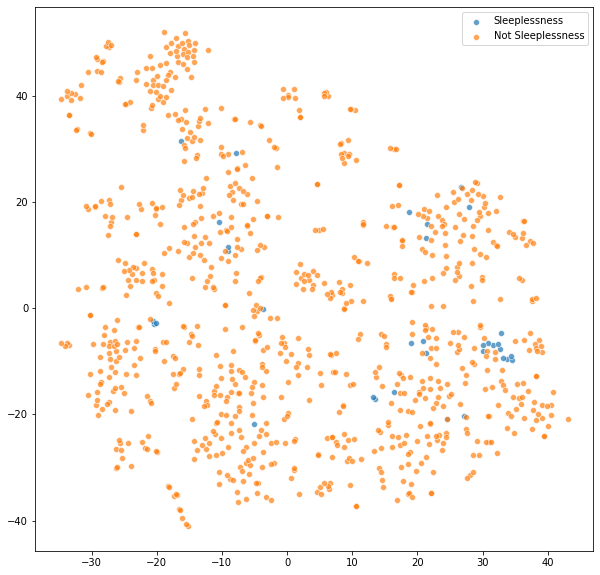

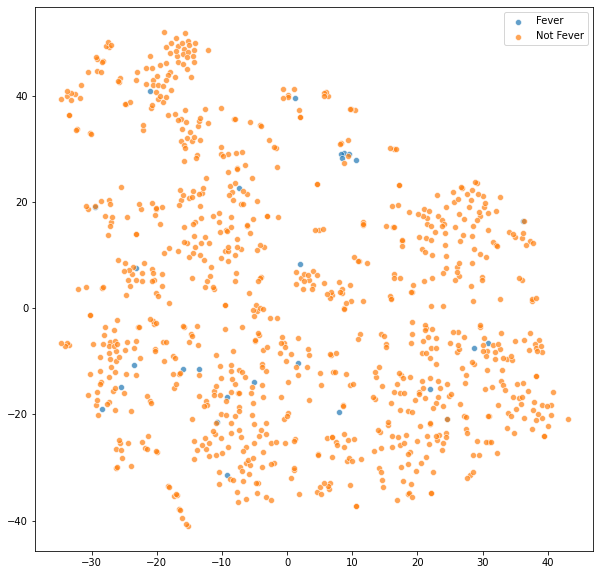

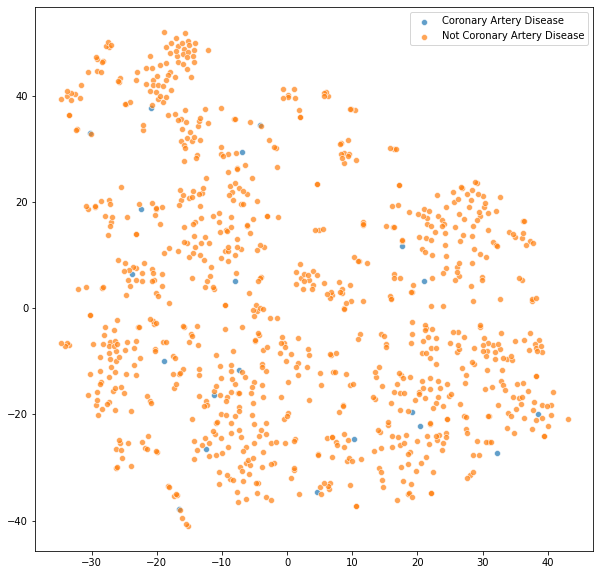

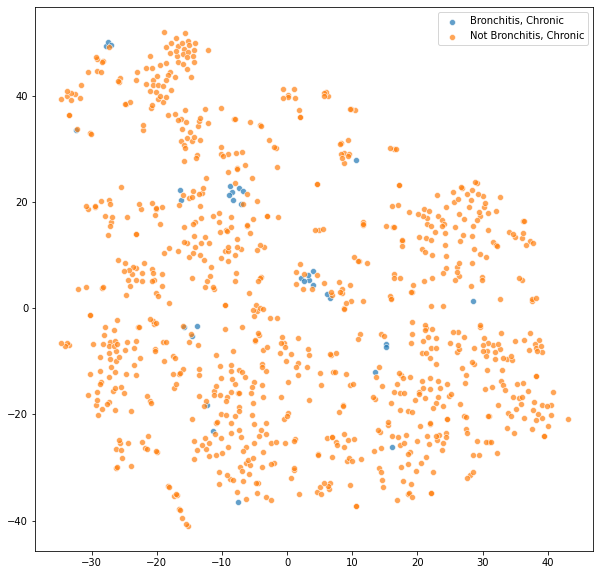

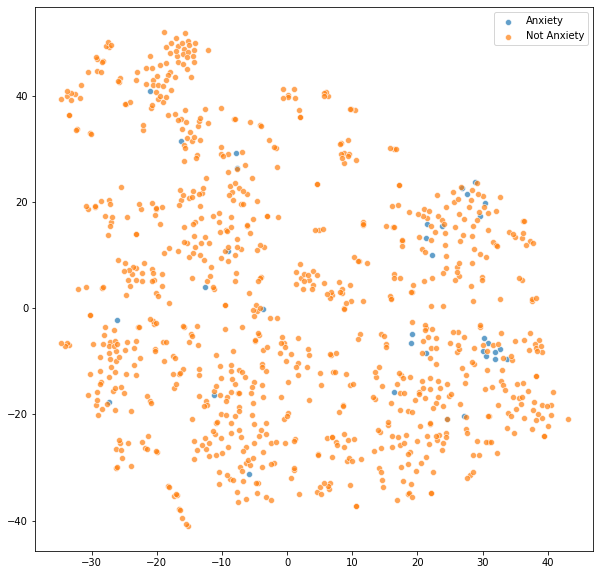

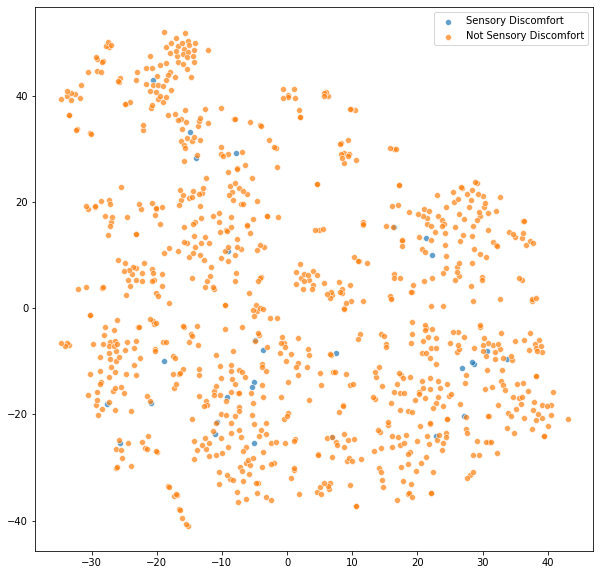

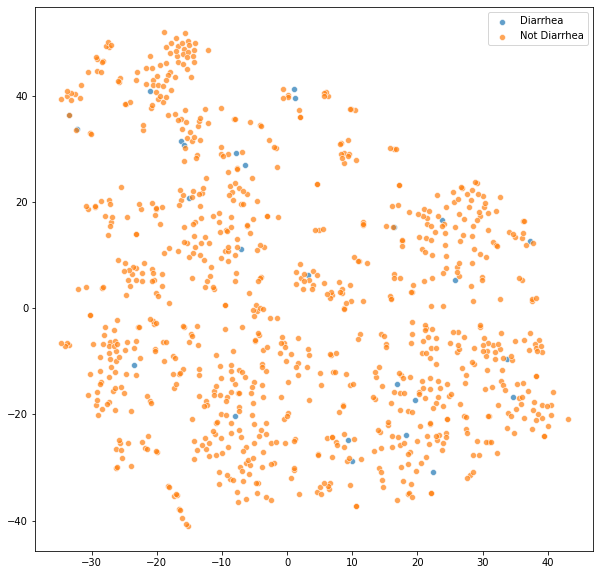

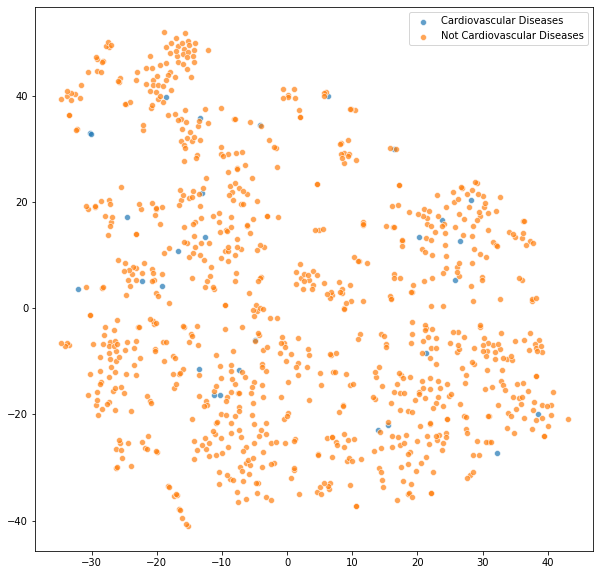

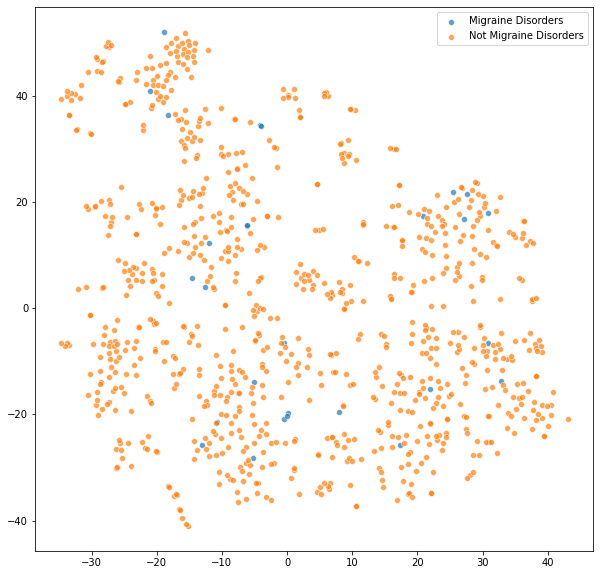

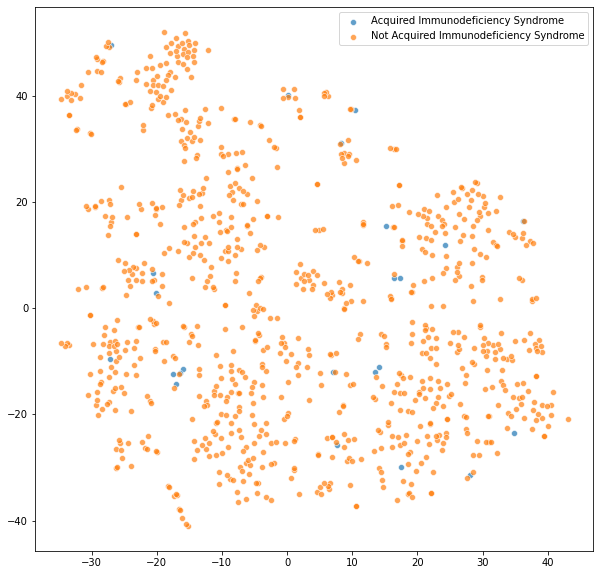

In [158]:
for a in top_ADR:
    get_graph(df, X_2d, a, ADR_dict, name_UML)

In [159]:
df.shape

(926, 301)